<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# [учебный проект]

#  Прогнозирование заказов такси для аэропорта

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки.

<font color='blue'>  <p> 
<b> Описание целей и задачи проекта:</b>
<p>Требуется построить модель для прогнозирования количества заказов такси на следующий час.
<p>Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.
<p>
<hr>
<b> Описание данных: </b>

<b> Признаки </b>
<p>num_orders — количество заказов такси
<p>

<b>Целевой признак<b>
<p> num_orders - количество заказов такси (евро)

<hr>

<b> План работы:  </b>
    
<p> 1. Загрузить данные и выполнить их ресемплирование по одному часу.
<p> 2. Проанализировать данные. 
<p> 3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
<p> 4. Проверить данные на тестовой выборке и сделать выводы.    
</div>

## Подготовка
Загрузим данные и выполним их ресемплирование по одному часу.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

In [3]:
try:
    df = pd.read_csv('taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [4]:
# функция для изучения данных
def see(df):
    print('размер таблицы')
    print(df.shape)
    print('_'*20)
    print('название колонок')
    print(df.columns)
    print('_'*20)
    print('проверка на наличие пропусков')
    print(df.isna().sum())
    print('_'*20)
    print('общая информация о колонках данных')
    print(df.info())
    print('_'*20)
    print('5 верхних строк из таблицы')
    display(df.head())
    print('_'*20)
    print('описание данных')
    display(df.describe())
    
see(df)

размер таблицы
(4416, 1)
____________________
название колонок
Index(['num_orders'], dtype='object')
____________________
проверка на наличие пропусков
num_orders    0
dtype: int64
____________________
общая информация о колонках данных
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None
____________________
5 верхних строк из таблицы


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


____________________
описание данных


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


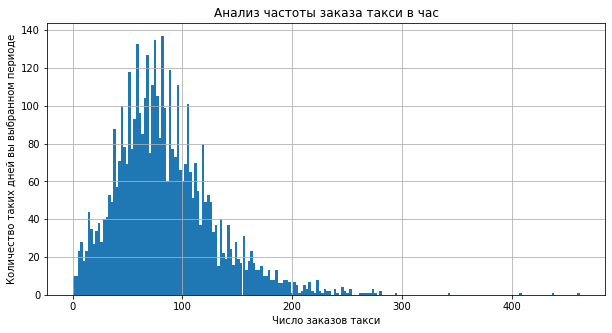

In [5]:
df['num_orders'].hist(bins=200, 
                      range=(df.num_orders.min(), 
                             df.num_orders.max()), 
                      figsize=(10, 5))
plt.title('Анализ частоты заказа такси в час')
plt.xlabel('Число заказов такси')
plt.ylabel('Количество таких дней вы выбранном периоде'); 

In [6]:
# рассмотренный временной интервал
print(df.index.min(), df.index.max())

2018-03-01 00:00:00 2018-08-31 23:00:00


In [7]:
df[df['num_orders']>300]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


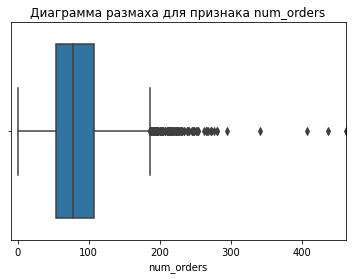

In [8]:
plt.xlim(df.num_orders.min()-10, df.num_orders.max())
sns.boxplot(df['num_orders'])
plt.title('Диаграмма размаха для признака num_orders');

In [10]:
def make_features(df, max_lag, rolling_mean_size):
#    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.week
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 6, 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4410 entries, 2018-03-01 06:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4410 non-null   int64  
 1   month         4410 non-null   int64  
 2   week          4410 non-null   int64  
 3   day           4410 non-null   int64  
 4   dayofweek     4410 non-null   int64  
 5   hour          4410 non-null   int64  
 6   lag_1         4410 non-null   float64
 7   lag_2         4410 non-null   float64
 8   lag_3         4410 non-null   float64
 9   lag_4         4410 non-null   float64
 10  lag_5         4410 non-null   float64
 11  lag_6         4410 non-null   float64
 12  rolling_mean  4410 non-null   float64
dtypes: float64(7), int64(6)
memory usage: 482.3 KB


/tmp/ipykernel_152/884440714.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week


## Анализ

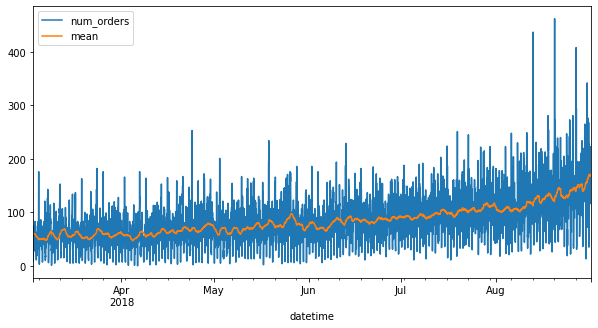

In [11]:
df['mean'] = df['num_orders'].rolling(48).mean()
df['std'] = df['num_orders'].rolling(48).std()
df = df.dropna()
df[['num_orders','mean']].plot(figsize=(10, 5));

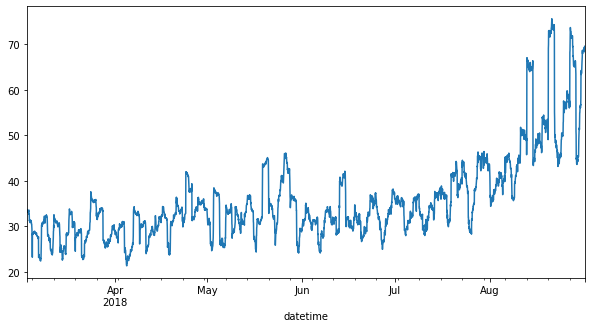

In [12]:
df['std'].plot(figsize=(10, 5));

In [13]:
df2 = df['num_orders']
df2.head()

test = sm.tsa.adfuller(df2)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.1609878517897756
p-value:  0.022356853096394694
Critical values:  {'1%': -3.431860429159128, '5%': -2.8622074237098976, '10%': -2.5671252743375543}
единичных корней нет, ряд стационарен


In [14]:
df.head()

,num_orders,month,week,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean,mean,std
datetime,,,,,,,,,,,,,,,
2018-03-03 05:00:00,15,3,9,3,5,5,44.0,64.0,25.0,108.0,163.0,72.0,44.0,60.291667,33.669203
2018-03-03 06:00:00,9,3,9,3,5,6,15.0,44.0,64.0,25.0,108.0,163.0,15.0,60.229167,33.763407
2018-03-03 07:00:00,17,3,9,3,5,7,9.0,15.0,44.0,64.0,25.0,108.0,9.0,60.270833,33.707591
2018-03-03 08:00:00,56,3,9,3,5,8,17.0,9.0,15.0,44.0,64.0,25.0,17.0,60.729167,33.491656
2018-03-03 09:00:00,73,3,9,3,5,9,56.0,17.0,9.0,15.0,44.0,64.0,56.0,60.812500,33.517640


In [15]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [16]:
features_train.shape

(3926, 14)

<div> <b> Примечание: </div>
<font color='blue'>
<p> Данные разделены в нужной пропроции, можно переходить к обучению.

## Обучение

In [17]:
# функция метрики
def rmse(targets, predictions):
    differences = predictions - targets                       
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()  
    rmse_val = np.sqrt(mean_of_differences_squared)           
    return rmse_val

rmse_score = make_scorer(rmse, greater_is_better = False)

In [19]:
print('Выводы:')
print('Получены следующие результаты:')
print('Модель 1 - линейная регрессия')
model1 = LinearRegression()
model1.fit(features_train, target_train)
predictions_train = model1.predict(features_train)  
predictions_test = model1.predict(features_test) 
print("RMSE обучающей выборки LinearRegression():", 
      rmse(target_train, predictions_train))
print("RMSE тестовой выборки LinearRegression(): ", 
      rmse(target_test, predictions_test))

print('_'*20)
print('Модель 2 - дерево решений')
model2 = DecisionTreeRegressor(random_state=11) 
param = {'max_depth': range(1,10,2),
        'min_samples_leaf':range(1,6),
        'min_samples_split':range(2,5)}

model2.fit(features_train, target_train)
predictions_train = model2.predict(features_train)
predictions_test = model2.predict(features_test)
print("RMSE обучающей выборки DecisionTreeRegressor:", 
      rmse(target_train, predictions_train))
print("RMSE тестовой выборки DecisionTreeRegressor: ", 
      rmse(target_test, predictions_test))

print('_'*20)
print('Модель 3 - случайный лес')
for depth in range(1, 10, 1):
    model3 = RandomForestRegressor(n_estimators=10, max_depth=depth, random_state=12345)
    model3.fit(features_train, target_train)
    predictions_train = model3.predict(features_train)
    predictions_test = model3.predict(features_test)
print("RMSE обучающей выборки RandomForestRegressor:", 
      rmse(target_train, predictions_train))
print("RMSE тестовой выборки RandomForestRegressor: ", 
      rmse(target_test, predictions_test))

print('_'*20)
print('Модель 4 - градиентный бустинг от Билла')
model4 = LGBMRegressor()

model4.fit(features_train, target_train)
predictions_train = model4.predict(features_train)
predictions_test = model4.predict(features_test)
print("RMSE обучающей выборки LGBMRegressor():", 
      rmse(target_train, predictions_train))
print("RMSE тестовой выборки LGBMRegressor(): ", 
      rmse(target_test, predictions_test))

Выводы:
Получены следующие результаты:
Модель 1 - линейная регрессия
RMSE обучающей выборки LinearRegression(): 30.36379514469675
RMSE тестовой выборки LinearRegression():  50.288736442720015
____________________
Модель 2 - дерево решений
RMSE обучающей выборки DecisionTreeRegressor: 0.0
RMSE тестовой выборки DecisionTreeRegressor:  56.89671078314197
____________________
Модель 3 - случайный лес
RMSE обучающей выборки RandomForestRegressor: 17.10856676925127
RMSE тестовой выборки RandomForestRegressor:  46.1330548477428
____________________
Модель 4 - градиентный бустинг от Билла
RMSE обучающей выборки LGBMRegressor(): 14.299042702482353
RMSE тестовой выборки LGBMRegressor():  41.25144333334495


## Выводы

<div> <b> Выводы: </div>
<font color='blue'>
<hr>
<p> На тестовой выборке были получены результаты:
<p> Получены следующие результаты:
<p>Модель 1 - линейная регрессия
<p>RMSE тестовой выборки LinearRegression():  34.91076404209983
<p>Модель 2 - дерево решений
<p>RMSE тестовой выборки DecisionTreeRegressor:  48.611255051140766
<p>Модель 3 - случайный лес
<p>RMSE тестовой выборки RandomForestRegressor:  39.84635075609207
<p>Модель 4 - градиентный бустинг от Билла
<p>RMSE тестовой выборки LGBMRegressor():  39.235829765059414
<p> Рекомендую к использованию модель с оптимальныеми результатами: LGBMRegressor()

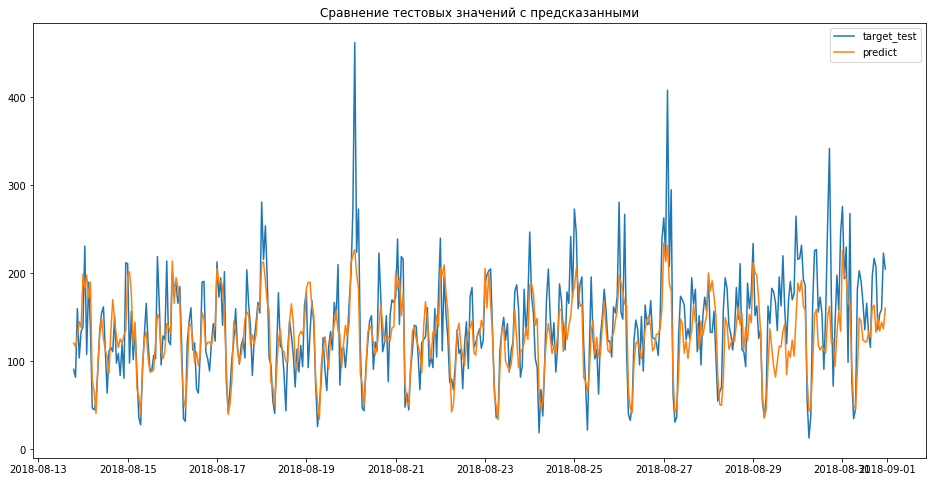

In [23]:
plt.figure(figsize=(16, 8))

plt.plot(target_test, label='target_test')
plt.plot(target_test.index, predictions_test, label='predict')

plt.title('Сравнение тестовых значений с предсказанными')
plt.legend()
plt.show()